In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cardiomegaly-disease-prediction-using-cnn/test/test/false/173.png
/kaggle/input/cardiomegaly-disease-prediction-using-cnn/test/test/false/491.png
/kaggle/input/cardiomegaly-disease-prediction-using-cnn/test/test/false/379.png
/kaggle/input/cardiomegaly-disease-prediction-using-cnn/test/test/false/248.png
/kaggle/input/cardiomegaly-disease-prediction-using-cnn/test/test/false/94.png
/kaggle/input/cardiomegaly-disease-prediction-using-cnn/test/test/false/480.png
/kaggle/input/cardiomegaly-disease-prediction-using-cnn/test/test/false/236.png
/kaggle/input/cardiomegaly-disease-prediction-using-cnn/test/test/false/340.png
/kaggle/input/cardiomegaly-disease-prediction-using-cnn/test/test/false/48.png
/kaggle/input/cardiomegaly-disease-prediction-using-cnn/test/test/false/513.png
/kaggle/input/cardiomegaly-disease-prediction-using-cnn/test/test/false/350.png
/kaggle/input/cardiomegaly-disease-prediction-using-cnn/test/test/false/314.png
/kaggle/input/cardiomegaly-disease-predict

In [179]:
#kütüphane ve ortam kurulumuj 
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import timm
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score, accuracy_score
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import warnings
warnings.filterwarnings('ignore')


In [180]:
# CUDA ayarı
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Kullanılan Cihaz: {DEVICE}")

Kullanılan Cihaz: cuda


In [181]:
def set_seed(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # Hız için bazı durumlarda kapatılır, ancak kesin sonuçlar için önerilir:
        # torch.backends.cudnn.deterministic = True 
        # torch.backends.cudnn.benchmark = False
        
set_seed(42)
print("Rastgelelik tohumu (Seed) 42 olarak ayarlandı.")

Rastgelelik tohumu (Seed) 42 olarak ayarlandı.


In [182]:
#custom dataet olusturma 
class CardiomegalyDataset(Dataset):
    """
    Kardiyomegali X-Ray görüntülerini PyTorch Tensörüne dönüştüren özel Dataset sınıfı.
    """
    def __init__(self, df, transforms=None):
        self.df = df
        self.transforms = transforms
        # etiketleri doğrudan tamsayıya eşliyoruz
        self.label_map = {'True': 1, 'False': 0}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        #  Dosya yolu ve etiketi al
        row = self.df.iloc[idx]
        file_path = row['filepath']
        label_str = row['label']
        
        #  Görüntüyü oku 
        #   bozuk veya eksik dosyalar olabilir.
        try:
            image = cv2.imread(file_path)
            # cv2 BGR okuduğu için RGB'ye çeviriyoruz
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except Exception as e:
             #
             print(f"Uyarı: Dosya yüklenemedi: {file_path}. Hata: {e}")
             
            

        # 3. Transformasyonları uygula
        if self.transforms:
            # Albumentations dict formatında çalışır
            
            image = self.transforms(image=image)['image']
            
        # 4. Etiketi tamsayıya çevir ve Tensör yap
        label = torch.tensor(self.label_map[label_str], dtype=torch.long)
        
        return image, label

print("CardiomegalyDataset sınıfı başarıyla tanımlandı.")

CardiomegalyDataset sınıfı başarıyla tanımlandı.


In [193]:
#dataframe hazırlaama 
# Dosya yolları ve DataFrame oluşturma (Kaggle simülasyonu)
ROOT_DIR = "/kaggle/input/cardiomegaly-disease-prediction-using-cnn/"
label_folders = ['true', 'false']
subset_to_use = 'train'

In [195]:
data = []
subset_path = os.path.join(ROOT_DIR, subset_to_use) 
base_path_to_search = os.path.join(subset_path, subset_to_use)

In [196]:
for label_folder in label_folders:
    final_path = os.path.join(base_path_to_search, label_folder) # Örn: .../train/train/true/
    
    # Klasör varlığını kontrol et
    if os.path.isdir(final_path):
        # Klasördeki tüm görüntüleri topla
        for img_file in os.listdir(final_path):
            if img_file.endswith(('.png', '.jpg', '.jpeg')): 
                data.append({
                    'filepath': os.path.join(final_path, img_file),
                    # Label: 'true' -> True (1), 'false' -> False (0)
                    'label': 'True' if label_folder == 'true' else 'False' 
                })
        print(f"Buldum! {final_path} klasöründen {len(os.listdir(final_path))} dosya eklendi.")
    else:
        print(f"UYARI: Beklenen {final_path} klasörü bulunamadı.")

Buldum! /kaggle/input/cardiomegaly-disease-prediction-using-cnn/train/train/true klasöründen 2219 dosya eklendi.
Buldum! /kaggle/input/cardiomegaly-disease-prediction-using-cnn/train/train/false klasöründen 2219 dosya eklendi.


In [197]:
full_df = pd.DataFrame(data)

In [199]:
if full_df.empty:
    raise ValueError("DataFrame boş. Görüntü dosyaları doğru yolda bulunamadı.")

In [200]:
# Stratified Shuffle Split için gerekli kütüphaney
from sklearn.model_selection import StratifiedShuffleSplit

In [201]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
for train_index, valid_index in splitter.split(full_df, full_df['label']):
    train_df = full_df.iloc[train_index].reset_index(drop=True)
    valid_df = full_df.iloc[valid_index].reset_index(drop=True)

In [202]:
print("\n--- Veri Seti Özeti ---")
print(f"Eğitim için Toplam Kullanılan Görüntü (train klasöründen): {len(full_df)}")
print(f"Nihai Eğitim Seti (90%): {len(train_df)}")
print(f"Nihai Doğrulama Seti (10%): {len(valid_df)}")
print("\nEğitim Etiket Dağılımı (Kardiyomegali True / Normal False):\n", train_df['label'].value_counts(normalize=True))
print("Doğrulama Etiket Dağılımı (Kardiyomegali True / Normal False):\n", valid_df['label'].value_counts(normalize=True))


--- Veri Seti Özeti ---
Eğitim için Toplam Kullanılan Görüntü (train klasöründen): 4438
Nihai Eğitim Seti (90%): 3994
Nihai Doğrulama Seti (10%): 444

Eğitim Etiket Dağılımı (Kardiyomegali True / Normal False):
 label
True     0.5
False    0.5
Name: proportion, dtype: float64
Doğrulama Etiket Dağılımı (Kardiyomegali True / Normal False):
 label
False    0.5
True     0.5
Name: proportion, dtype: float64


In [204]:
#Albumentations Pipeline (Transformasyonlar)
#modelin beklediği 224x224 boyutuna getirme, normalizasyon ve modelin genelleme yeteneğini artıracak veri artırma (Augmentation) zincirlerini tanımlıyoruz.
IMAGE_SIZE = 224

In [206]:
train_transforms = A.Compose([
   
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    
    
    A.HorizontalFlip(p=0.5), # Yatay çevirme
    A.Rotate(limit=10, p=0.5), # ±10 dereceye kadar döndürme
    A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.2), 
    
    
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.2), 
    
   
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    
  
    ToTensorV2(),
])

In [207]:
valid_transforms = A.Compose([
   
    A.Resize(IMAGE_SIZE, IMAGE_SIZE), 
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

In [208]:
print("Albumentations transformasyon pipeline'ları tanımlandı.")

Albumentations transformasyon pipeline'ları tanımlandı.


In [209]:
#Dataset DataLoadaer
train_dataset = CardiomegalyDataset(train_df, transforms=train_transforms)
valid_dataset = CardiomegalyDataset(valid_df, transforms=valid_transforms)

In [211]:
BATCH_SIZE = 32 # GPU belleğime uygun bir başlangıç
NUM_WORKERS = 4 # Veri okumayı hızlandır

In [212]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True, # Eğitim için karıştırma şart
    num_workers=NUM_WORKERS,
    pin_memory=True, # GPU'ya hızlı transfer için
)

In [213]:
valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, # Doğrulamada karıştırmaya gerek yok, tutarlılık önemli
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

In [214]:
# Kontrol: İlk batch'in boyutunu görelim
x, y = next(iter(train_loader))
print(f"Eğitim Batch Boyutu: Görüntü: {x.shape}, Etiket: {y.shape}") 
print(f"Veri tipi: Görüntü: {x.dtype}, Etiket: {y.dtype}")

Eğitim Batch Boyutu: Görüntü: torch.Size([32, 3, 224, 224]), Etiket: torch.Size([32])
Veri tipi: Görüntü: torch.float32, Etiket: torch.int64


In [217]:
#Görsel Kontrol EDA
import matplotlib.pyplot as plt
# Normalizasyonu tersine çevirme fonksiyonu (görüntüleyebilmek için)
def denormalize(tensor):
    # Not: Normalizasyonu tersine çeviriyorum ki piksel değerleri görülebilsin.
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    # Tensor üzerinde işlemi yap ve 0-1 aralığına sıkıştır
    tensor = tensor.clone() * std + mean
    tensor = torch.clamp(tensor, 0, 1)
    return tensor

In [219]:
images, labels = next(iter(train_loader))
# Rastgele 4 örneği görselleştirelim
plt.figure(figsize=(12, 12))
plt.suptitle("Eğitim Seti Görüntüleri ve Uygulanan Augmentasyonlar (Kontrol)", fontsize=16)

Text(0.5, 0.98, 'Eğitim Seti Görüntüleri ve Uygulanan Augmentasyonlar (Kontrol)')

<Figure size 1200x1200 with 0 Axes>

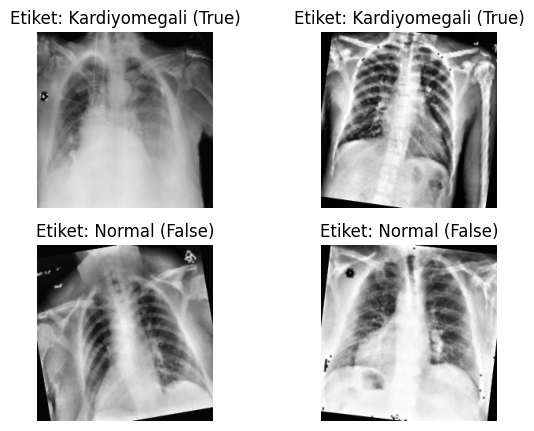


Veri yükleme ve Augmentation görsel kontrolü tamamlandı. Her şey yolunda.


In [222]:
for i in range(4):
    ax = plt.subplot(2, 2, i + 1)
    # Denormalize et, Tensör formatından (CHW) NumPy formatına (HWC) çevir
    img = denormalize(images[i]).permute(1, 2, 0).numpy()
    
    # Etiketi metne çevir
    label_text = "Kardiyomegali (True)" if labels[i].item() == 1 else "Normal (False)"
    
    plt.imshow(img)
    plt.title(f"Etiket: {label_text}")
    plt.axis("off")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
print("\nVeri yükleme ve Augmentation görsel kontrolü tamamlandı. Her şey yolunda.")

In [273]:

#EfficientNetB0 
MODEL_NAME = 'tf_efficientnet_b1_ns'  #modeli dğeiştirdim skor artmıyor diye 
NUM_CLASSES = 2 # Kardiyomegali (1) ve Normal (0)

In [274]:
class CardiomegalyModel(nn.Module):
    def __init__(self, model_name=MODEL_NAME, num_classes=NUM_CLASSES, pretrained=True):
        super().__init__()
       
        self.model = timm.create_model(model_name, pretrained=pretrained)
        
       
        num_ftrs = self.model.classifier.in_features
        
        
        self.model.classifier = nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

In [275]:
#modeli oluşturuyorum , GPU'ya gönder ve özetini yazdır
model = CardiomegalyModel().to(DEVICE)
print(f"Model: {MODEL_NAME} başarıyla kuruldu ve {DEVICE} üzerine taşındı.")

model.safetensors:   0%|          | 0.00/31.5M [00:00<?, ?B/s]

Model: tf_efficientnet_b1_ns başarıyla kuruldu ve cuda üzerine taşındı.


In [276]:
# toplam parametre sayısını görelim (kontrol)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Toplam Parametre Sayısı: {total_params / 1e6:.2f} Milyon")
print(f"Eğitilebilir Parametre Sayısı: {trainable_params / 1e6:.2f} Milyon")

Toplam Parametre Sayısı: 6.52 Milyon
Eğitilebilir Parametre Sayısı: 6.52 Milyon


In [228]:
#MixUp ve CutMix Fonksiyonları
#DataBasedRegulariziton

def mixup_data(x, y, alpha=1.0, device='cuda'):
    '''
    MixUp Veri Artırma Yöntemi
    Görüntüleri ve etiketleri karıştırır.
    '''
    if alpha > 0:
        # Beta dağılımından lambda değeri çek
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    # Batch içindeki indeksleri rastgele karıştır
    index = torch.randperm(batch_size).to(device)

    # Görüntüleri ve etiketleri karıştır
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    
    return mixed_x, y_a, y_b, lam

In [229]:
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    '''
    MixUp için özel kayıp fonksiyonu (Loss)
    İki etiketin karışımına göre kayıp hesaplanır.
    '''
    # Klasik CrossEntropyLoss, karışım oranına (lam) göre ağırlıklandırılır.
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

In [233]:
def cutmix_data(x, y, alpha=1.0, device='cuda'):
    '''
    CutMix Veri Artırma Yöntemi
    İki görüntünün rastgele bir bölgesini kesip yapıştırır.
    '''
    if alpha > 0:
        # Beta dağılımından lambda değeri çek
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    #  Kutu (Bbox) koordinatlarını hesapla
    # 
    H, W = x.shape[2:] # Görüntü boyutları (224, 224)
    r = np.sqrt(1 - lam) # Kesilecek alanın karekökü
    
    # kesilecek kutunun merkez koordinatları
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    # kutu genişliği ve yüksekliği
    cut_w = np.int64(W * r)
    cut_h = np.int64(H * r)

    #kKutu sınırları (0-W ve 0-H içinde kalmalı)
    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    #görüntüleri karıştır 
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(device) # Karıştırılacak görüntünün indeksi
    
    mixed_x = x.clone()
    #ıllk görüntünün kutu bölgesine ikinci görüntünün kutu bölgesini kopyala
    mixed_x[:, :, bby1:bby2, bbx1:bbx2] = x[index, :, bby1:bby2, bbx1:bbx2]
    
    # gerçrçek Lambda değerini yeniden hesapla (kesilen alana göre)
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (W * H))
    
    y_a, y_b = y, y[index]
    
    return mixed_x, y_a, y_b, lam

In [235]:
print("MixUp ve CutMix yardımcı fonksiyonları tanımlandı.")

MixUp ve CutMix yardımcı fonksiyonları tanımlandı.


In [236]:
#model training
NUM_EPOCHS = 20          # başlangıçta 15 epoch deneyerum ** 20ye değiştirdim skoru arttırmak için 2.ci denemem bu 
LR = 2e-4                 # adamw için iyi bir başlangıç öğrenme oranı
WEIGHT_DECAY = 1e-5       # aşırı öğrenmeyi engellemek için ağırlık çürümesi
MIXUP_ALPHA = 0.4         # mixup için lambda dağılım parametresi
CUTMIX_ALPHA = 0.8        # cutmix için lambda dağılım parametresi
APPLY_MIXUP = True        # mixup kullanılsın mı?
APPLY_CUTMIX = True       # cutmix kullanılsın mı?

In [237]:
#loss optimizer ve schedular 
criterion = nn.CrossEntropyLoss() # ikili sınıflandırma için standart kayıp fonksiyonu
optimizer = optim.AdamW(
    model.parameters(), 
    lr=LR, 
    weight_decay=WEIGHT_DECAY
)

In [249]:
# YENİ SCHEDULER: Cosine Annealing LR
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=NUM_EPOCHS, # T_max: LR döngüsünün kaç epoch'ta tamamlanacağını söyler (20 epoch).
    eta_min=1e-6      # eta_min: Öğrenme hızının düşebileceği en düşük değer.
)




In [258]:

from tqdm.auto import tqdm

In [260]:
#yardımcı eğitim fonksiyonu 
def train_one_epoch(model, dataloader, criterion, optimizer, epoch, mixup_alpha=0.0, cutmix_alpha=0.0):
    model.train() # modeli eğitim moduna al
    running_loss = 0.0
    
   
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f"Epoch {epoch} (Train)")
    
    # her batch üzerinde döngü
    # döngüyü pbar üzerinden başlatıyoruz, inputs ve labels değerlerini alıyoruz.
    for batch_idx, (inputs, labels) in pbar:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        # mixup veya cutmix uygulama mantığı aynı kalır 
        r = np.random.rand(1)
        
        if mixup_alpha > 0 and r < 0.5 and APPLY_MIXUP:
            inputs, labels_a, labels_b, lam = mixup_data(inputs, labels, mixup_alpha, DEVICE)
            outputs = model(inputs)
            loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)
        
        elif cutmix_alpha > 0 and r >= 0.5 and APPLY_CUTMIX:
            inputs, labels_a, labels_b, lam = cutmix_data(inputs, labels, cutmix_alpha, DEVICE)
            outputs = model(inputs)
            loss = mixup_criterion(criterion, outputs, labels_a, labels_b, lam)

        else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # optimizasyon adımı
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        
        # tqdm çubuğunun sonuna o anki kaybı (loss) ekle
        pbar.set_postfix({'Loss': f'{loss.item():.4f}'})

    epoch_loss = running_loss / len(dataloader.dataset)
    # console çıktısını sadece epoch sonunda veriyoruz
    print(f"Epoch {epoch} | Train Loss: {epoch_loss:.4f}")
    return epoch_loss

In [261]:
#evaluate fonksiyonu 
def evaluate(model, dataloader, criterion):
    model.eval() # modeli değerlendirme moduna al
    running_loss = 0.0
    all_preds = []
    all_targets = []
    
    with torch.no_grad(): # gradyan hesaplamasını kapat
        for inputs, labels in dataloader:
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            
            # metrikler için: olasılıkları al (softmax uygulamadan)
            # roc-auc için softmax öncesi skorlar (logits) kullanılır
            probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy() # kardiyomegali (1) olasılığı
            preds = torch.argmax(outputs, dim=1).cpu().numpy() # sınıf tahminleri
            
            all_preds.extend(probs)
            all_targets.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader.dataset)
    # roc_auc ve accuracy hesapla
    roc_auc = roc_auc_score(all_targets, all_preds)
    accuracy = accuracy_score(all_targets, (np.array(all_preds) > 0.5).astype(int))
    
    print(f"Valid Loss: {epoch_loss:.4f} | Valid Acc: {accuracy:.4f} | Valid ROC-AUC: {roc_auc:.4f}")
    return epoch_loss, accuracy, roc_auc

In [265]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm # İlerleme çubuğu için
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score
import os

In [279]:
best_roc_auc = 0.0 # 
patience_counter = 0
MAX_PATIENCE = 7 # Erken durdurma sabrı
MODEL_SAVE_PATH = 'best_cardiomegaly_model_B1.pth' # Hata veren değişkenin tanımı
NUM_EPOCHS = 20 


model = CardiomegalyModel().to(DEVICE)

print(f"!!! Yükleme Atlandı: EfficientNet-B1 modeli ImageNet ağırlıkları ile sıfırdan başlıyor !!!")
'''
#En iyi bilinen ağırlıkları yükle!
try:
   
    model.load_state_dict(torch.load(MODEL_SAVE_PATH))
    print(f"!!! En iyi bilinen ağırlıklar (ROC-AUC: {best_roc_auc}) yüklendi. Eğitime buradan devam ediliyor !!!")
except FileNotFoundError:
    print(f"Uyarı: {MODEL_SAVE_PATH} bulunamadı. Sıfırdan başlıyor. best_roc_auc: 0.0 yapıldı.")
    best_roc_auc = 0.0 # Eğer dosya yoksa, gerçekten sıfırdan başla.
 '''   

optimizer = optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)


print("\n--- YENİ EĞİTİM BAŞLIYOR (Cosine Annealing ile,EfficientNet-B1 Model ile  V7) ---")

# --- EĞİTİM DÖNGÜSÜ ---
for epoch in range(1, NUM_EPOCHS + 1):
    # eğitim (train_one_epoch'un tanımlı olduğunu varsayıyoruz)
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, epoch, MIXUP_ALPHA, CUTMIX_ALPHA)
    
    # değerlendirme (evaluate'in tanımlı olduğunu varsayıyoruz)
    valid_loss, valid_acc, valid_roc_auc = evaluate(model, valid_loader, criterion)
    
    # Cosine Annealing adımını at
    scheduler.step()
    
    # en iyi modeli kaydet ve sabır sayacını güncelle
    if valid_roc_auc > best_roc_auc:
        best_roc_auc = valid_roc_auc
        patience_counter = 0 # skor iyileşti, ssıfırla
        # en iyi model ağırlıklarını kaydet
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"!!! Yeni En İyi Model Kaydedildi (ROC-AUC: {best_roc_auc:.4f}) !!!")
    else:
        patience_counter += 1 # skor iyileşmedi, sabır sayacını artır

    # erken durdurma (early stopping)
    if patience_counter >= MAX_PATIENCE:
        print(f"\nErken Durdurma: {MAX_PATIENCE} epoch boyunca iyileşme olmadı. Eğitim Durduruldu.")
        break
    
print("\n--- Eğitim Tamamlandı ---")
print(f"Elde Edilen En İyi Valid ROC-AUC: {best_roc_auc:.4f}")

!!! Yükleme Atlandı: EfficientNet-B1 modeli ImageNet ağırlıkları ile sıfırdan başlıyor !!!

--- YENİ EĞİTİM BAŞLIYOR (Cosine Annealing ile,Yeni Model ile  V7) ---


Epoch 1 (Train):   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 0.6423
Valid Loss: 0.5369 | Valid Acc: 0.7252 | Valid ROC-AUC: 0.8057
!!! Yeni En İyi Model Kaydedildi (ROC-AUC: 0.8057) !!!


Epoch 2 (Train):   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 2 | Train Loss: 0.5822
Valid Loss: 0.5057 | Valid Acc: 0.7432 | Valid ROC-AUC: 0.8435
!!! Yeni En İyi Model Kaydedildi (ROC-AUC: 0.8435) !!!


Epoch 3 (Train):   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 3 | Train Loss: 0.5480
Valid Loss: 0.5048 | Valid Acc: 0.7432 | Valid ROC-AUC: 0.8436
!!! Yeni En İyi Model Kaydedildi (ROC-AUC: 0.8436) !!!


Epoch 4 (Train):   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 4 | Train Loss: 0.5505
Valid Loss: 0.4949 | Valid Acc: 0.7680 | Valid ROC-AUC: 0.8476
!!! Yeni En İyi Model Kaydedildi (ROC-AUC: 0.8476) !!!


Epoch 5 (Train):   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 5 | Train Loss: 0.5175
Valid Loss: 0.4889 | Valid Acc: 0.7725 | Valid ROC-AUC: 0.8472


Epoch 6 (Train):   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 6 | Train Loss: 0.5123
Valid Loss: 0.4858 | Valid Acc: 0.7590 | Valid ROC-AUC: 0.8487
!!! Yeni En İyi Model Kaydedildi (ROC-AUC: 0.8487) !!!


Epoch 7 (Train):   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 7 | Train Loss: 0.5027
Valid Loss: 0.5171 | Valid Acc: 0.7477 | Valid ROC-AUC: 0.8264


Epoch 8 (Train):   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 8 | Train Loss: 0.4810
Valid Loss: 0.5058 | Valid Acc: 0.7432 | Valid ROC-AUC: 0.8366


Epoch 9 (Train):   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 9 | Train Loss: 0.4502
Valid Loss: 0.5025 | Valid Acc: 0.7500 | Valid ROC-AUC: 0.8379


Epoch 10 (Train):   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 10 | Train Loss: 0.4329
Valid Loss: 0.5105 | Valid Acc: 0.7545 | Valid ROC-AUC: 0.8449


Epoch 11 (Train):   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 11 | Train Loss: 0.4218
Valid Loss: 0.5056 | Valid Acc: 0.7500 | Valid ROC-AUC: 0.8462


Epoch 12 (Train):   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 12 | Train Loss: 0.3944
Valid Loss: 0.5253 | Valid Acc: 0.7613 | Valid ROC-AUC: 0.8303


Epoch 13 (Train):   0%|          | 0/125 [00:00<?, ?it/s]

Epoch 13 | Train Loss: 0.4253
Valid Loss: 0.4980 | Valid Acc: 0.7770 | Valid ROC-AUC: 0.8426

Erken Durdurma: 7 epoch boyunca iyileşme olmadı. Eğitim Durduruldu.

--- Eğitim Tamamlandı ---
Elde Edilen En İyi Valid ROC-AUC: 0.8487


ReduceLROnPlateau kullanıyordum bu lr'i 10 kat dusuren bir yönetim sımdı yöntem değiştiriecem cunku auc=0.8639 oldu bu  yöntemde daha iyisi lazım bana 
-yeni  yöntemim **Cosine Annealing LR**.bu öğrenme hızını her epoch'ta yumuşak bir sinüs eğrisi şeklinde, yüksekten en düşüğe (minimuma) ve sonra tekrar düşüğe çeken agresif bir yöntemdir
-

In [280]:
#Yenimodellerle denediğim yeni aşamalarla çalıştırdığım epochslarda daha dusuk skor aldım ondan doalyı eksi modeli yukleyip tta yapacam
#En İyi Skoru Veren Model Ağırlıklarını Yükleme
MODEL_NAME = 'tf_efficientnet_b0_ns' 
BEST_ROC_AUC = 0.8639 
MODEL_PATH = 'best_cardiomegaly_model.pth' # B0'ı kaydettiğimiz dosya

In [281]:
model = CardiomegalyModel(model_name=MODEL_NAME).to(DEVICE)

# Ağırlıkları yükle (B0 mimarisine B0 ağırlıklarını yüklüyoruz)
try:
    model.load_state_dict(torch.load(MODEL_PATH))
    print(f"!!! EfficientNet-B0 modeline {MODEL_PATH} ağırlıkları yüklendi. ROC-AUC: {BEST_ROC_AUC} !!!")
except FileNotFoundError:
    raise FileNotFoundError("HATA: B0 modeli ağırlıkları diskte bulunamadı. Lütfen best_cardiomegaly_model.pth dosyasının varlığını kontrol edin.")

print("Model, TTA için B0 mimarisinde hazır.")

!!! EfficientNet-B0 modeline best_cardiomegaly_model.pth ağırlıkları yüklendi. ROC-AUC: 0.8639 !!!
Model, TTA için B0 mimarisinde hazır.


In [284]:
#TestTimeAugmentation (TTA)
TTA_TRANSFORMS = [
    # 1. Normal (Referans)
    A.Compose([A.Resize(224, 224), A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ToTensorV2()]), 
    # 2. Yatay Çevirme (Yaygın TTA tekniği)
    A.Compose([A.HorizontalFlip(p=1), A.Resize(224, 224), A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ToTensorV2()]), 
    # 3. Hafif Döndürme (X-Ray'lerde işe yarayabilir)
    A.Compose([A.Rotate(limit=10, p=1), A.Resize(224, 224), A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), ToTensorV2()]), 
]

In [285]:
def apply_tta(model, df, transforms_list):
    model.eval() # Model değerlendirme modunda olmalı
    all_targets = []
    all_tta_probs = []

    # Her bir TTA versiyonu için tahminleri topla
    for tta_idx, transforms in enumerate(transforms_list):
        tta_dataset = CardiomegalyDataset(df, transforms=transforms) # CardiomegalyDataset tanımlı olmalı
        # DataLoader (BATCH_SIZE ve NUM_WORKERS tanımlı olmalı)
        tta_loader = DataLoader(tta_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
        
        current_probs = []
        with torch.no_grad():
            for inputs, labels in tta_loader:
                inputs = inputs.to(DEVICE)
                outputs = model(inputs)
                probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy() # Kardiyomegali (1) olasılığı
                
                current_probs.extend(probs)
                
                if tta_idx == 0:
                    all_targets.extend(labels.cpu().numpy()) # Sadece bir kere gerçek etiketleri al
        
        all_tta_probs.append(np.array(current_probs))
        print(f"TTA Versiyon {tta_idx+1} tamamlandı. ({len(current_probs)} tahmin)")

    # Tüm TTA tahminlerinin ortalamasını al
    all_tta_probs = np.array(all_tta_probs)
    final_avg_probs = np.mean(all_tta_probs, axis=0)

    # Nihai Metrik Hesaplama
    final_roc_auc = roc_auc_score(all_targets, final_avg_probs)
    final_accuracy = accuracy_score(all_targets, (final_avg_probs > 0.5).astype(int))
    
    return final_accuracy, final_roc_auc, all_targets, final_avg_probs

In [286]:
print("\n--- TTA Doğrulama Seti Üzerinde Uygulanıyor ---")
# valid_df değişkeninin tanımlı olduğunu varsayıyoruz
tta_acc, tta_auc, all_targets, all_probs = apply_tta(model, valid_df, TTA_TRANSFORMS)

print("---------------------------------------")
print(f"Final TTA Valid Acc: {tta_acc:.4f}")
print(f"Final TTA Valid ROC-AUC: {tta_auc:.4f} (Eski skor: {BEST_ROC_AUC})")
print("---------------------------------------")


--- TTA Doğrulama Seti Üzerinde Uygulanıyor ---
TTA Versiyon 1 tamamlandı. (444 tahmin)
TTA Versiyon 2 tamamlandı. (444 tahmin)
TTA Versiyon 3 tamamlandı. (444 tahmin)
---------------------------------------
Final TTA Valid Acc: 0.7838
Final TTA Valid ROC-AUC: 0.8638 (Eski skor: 0.8639)
---------------------------------------


In [287]:
#TestSeti DataLoadder
ROOT_DIR = "/kaggle/input/cardiomegaly-disease-prediction-using-cnn/"
subset_to_use = 'test' 
label_folders = ['true', 'false'] 
test_data = []

In [289]:
subset_path = os.path.join(ROOT_DIR, subset_to_use) 
base_path_to_search = os.path.join(subset_path, subset_to_use)

In [291]:
# Görüntü dosyalarını topl
for label_folder in label_folders:
    final_path = os.path.join(base_path_to_search, label_folder) 
    if os.path.isdir(final_path):
        for img_file in os.listdir(final_path):
            if img_file.endswith(('.png', '.jpg', '.jpeg')): 
                test_data.append({
                    'filepath': os.path.join(final_path, img_file),
                    'label': 'True' if label_folder == 'true' else 'False' 
                })

In [293]:
test_df = pd.DataFrame(test_data)
if test_df.empty:
    raise ValueError("Test DataFrame boş. Lütfen dosya yollarını kontrol edin.")

In [294]:
test_dataset = CardiomegalyDataset(test_df, transforms=valid_transforms) 

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, 
    num_workers=NUM_WORKERS,
    pin_memory=True,
)

print(f"Toplam Test Görüntüsü: {len(test_df)}")
print(f"Test Etiket Dağılımı:\n{test_df['label'].value_counts()}")
print("Test DataLoader oluşturuldu.")

Toplam Test Görüntüsü: 2228
Test Etiket Dağılımı:
label
True     1114
False    1114
Name: count, dtype: int64
Test DataLoader oluşturuldu.


In [295]:
model.eval() # Modeli değerlendirme moduna al
test_targets = []
test_probs = []
test_preds = []

In [296]:
print("\n--- NİHAİ TEST SETİ DEĞERLENDİRMESİ BAŞLIYOR ---")

with torch.no_grad():
    # tqdm ile ilerleme çubuğu ekliyoruz
    test_pbar = tqdm(test_loader, desc="Test Seti Analizi")
    for inputs, labels in test_pbar:
        inputs = inputs.to(DEVICE)
        
        outputs = model(inputs)
        
        # Olasılıkları ve sınıf tahminlerini al
        probs = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy() # Kardiyomegali olasılığı (ROC-AUC için)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()       # Sınıf tahmini (Accuracy, Confusion Matrix için)

        test_targets.extend(labels.cpu().numpy())
        test_probs.extend(probs)
        test_preds.extend(preds)

# Nihai Metrik Hesaplama
final_test_auc = roc_auc_score(test_targets, test_probs)
final_test_acc = accuracy_score(test_targets, test_preds)

print("---------------------------------------")
print(f"NİHAİ TEST ACCURACY: {final_test_acc:.4f}")
print(f"NİHAİ TEST ROC-AUC: {final_test_auc:.4f}")
print("---------------------------------------")


--- NİHAİ TEST SETİ DEĞERLENDİRMESİ BAŞLIYOR ---


Test Seti Analizi:   0%|          | 0/70 [00:00<?, ?it/s]

---------------------------------------
NİHAİ TEST ACCURACY: 0.7962
NİHAİ TEST ROC-AUC: 0.8711
---------------------------------------


In [297]:
#ConfusionMatrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [299]:
cm = confusion_matrix(test_targets, test_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] # Normalleştirilmiş matris

In [300]:
# Raporlama Metrikleri (Sensitivity/Recall ve Specificity)
recall_cardiomegaly = cm_normalized[1, 1] # True Positive Rate (Sensitivity)
specificity_normal = cm_normalized[0, 0]  # True Negative Rate (Specificity)
precision_cardiomegaly = cm[1, 1] / (cm[1, 1] + cm[0, 1])

In [301]:
print("--- Confusion Matrix Metrikleri ---")
print(f"Hassasiyet (Recall/Sensitivity - Hastayı bulma oranı): {recall_cardiomegaly:.4f}")
print(f"Özgüllük (Specificity - Sağlıklıyı bulma oranı): {specificity_normal:.4f}")
print(f"Kesinlik (Precision - Tahminlerin doğruluk oranı): {precision_cardiomegaly:.4f}")

--- Confusion Matrix Metrikleri ---
Hassasiyet (Recall/Sensitivity - Hastayı bulma oranı): 0.7882
Özgüllük (Specificity - Sağlıklıyı bulma oranı): 0.8043
Kesinlik (Precision - Tahminlerin doğruluk oranı): 0.8011


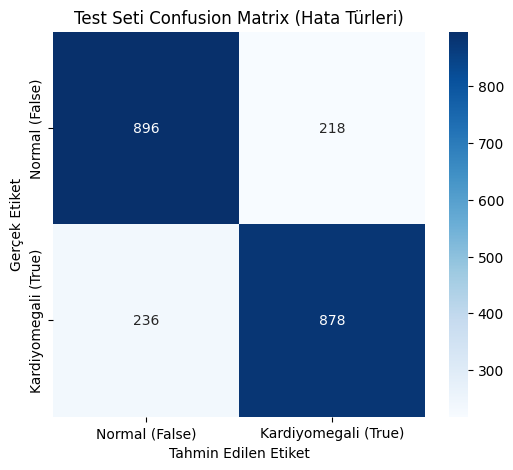

In [302]:
# Matrisi görselleştir
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Normal (False)', 'Kardiyomegali (True)'], 
            yticklabels=['Normal (False)', 'Kardiyomegali (True)'])
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.title('Test Seti Confusion Matrix (Hata Türleri)')
plt.show()

In [303]:
#roc eğrisi
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

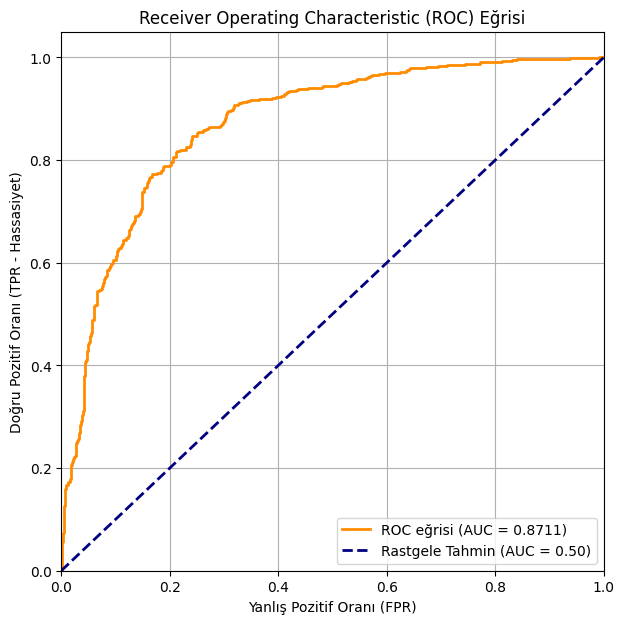

ROC Eğrisi çizildi. AUC skoru: 0.8711


In [304]:
fpr, tpr, thresholds = roc_curve(test_targets, test_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 7))
# Modelimizin ROC eğrisi
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC eğrisi (AUC = {roc_auc:.4f})')
# Rastgele tahmin çizgisi (50/50 şans)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Rastgele Tahmin (AUC = 0.50)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Yanlış Pozitif Oranı (FPR)')
plt.ylabel('Doğru Pozitif Oranı (TPR - Hassasiyet)')
plt.title('Receiver Operating Characteristic (ROC) Eğrisi')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f"ROC Eğrisi çizildi. AUC skoru: {roc_auc:.4f}")